In [1]:
# importing important libraries useful for the recommendation system 
import  pandas as pd # Python library for data analysis and dataframe work 
import numpy as np # numerical Python library for linear algebra and computation

pd.set_option('display.max_columns',None) # code to display all columns

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns


# libraries for text processing 
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# to display images 
from skimage import io

# to save the required files 
import pickle

import warnings
warnings.filterwarnings('ignore') # to prevent kernel from showning any warnings



In [2]:
df=pd.read_csv('movies.csv')
#df.shape

In [3]:
df.isnull().sum()

id                           0
title                        6
genres                  220700
original_language            0
overview                121133
popularity                   0
production_companies    399287
release_date             56781
budget                       0
revenue                      0
runtime                  38461
status                       0
tagline                 634509
vote_average                 0
vote_count                   0
credits                 231329
keywords                529469
poster_path             199099
backdrop_path           519126
recommendations         700806
dtype: int64

In [4]:
df.duplicated().sum()

173

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
#Let's check if there are any movies with same title
df['title'].duplicated().sum()

168415

In [7]:
#Wow! there are 168580 movies with same title. Now these might be duplicate movies but there's possibility that some might be different movies with same title
#Thats why Let's check if there are any movies with same title and same release date

df[['title','release_date']].duplicated().sum()

84372

In [8]:
# lets get rid of the duplicate movies
df.drop_duplicates(subset=['title','release_date'], inplace=True)

In [9]:
df.shape

(659948, 20)

**Now we have 6 lakh movies but most of the movies have 0 vote count. so we will consider only those movies which have at least more than 20 vote counts.**


In [10]:
# filtering the movies
df1 = df[df.vote_count >= 20].reset_index()

In [11]:
df1.isnull().sum()

index                       0
id                          0
title                       0
genres                    179
original_language           0
overview                  475
popularity                  0
production_companies     3306
release_date                2
budget                      0
revenue                     0
runtime                    16
status                      0
tagline                 20420
vote_average                0
vote_count                  0
credits                   647
keywords                 9576
poster_path               138
backdrop_path            2436
recommendations         11658
dtype: int64

In [12]:
# Replace the Nan with ''
df1.fillna('', inplace=True)

**Since i am making content based recommendation system and genres , overview are very important to find similar movies. So i will delete movies which don't have genres and overview.**

In [13]:
# finding index with '' genres and overview
index = df1[(df1['genres']=='') & (df1['overview']=='')].index

In [14]:
# droping those index
df1.drop(index, inplace=True)

In [15]:
columns_to_drop = ['popularity', 'production_companies', 'budget','revenue','status','vote_average']  # List of column names to drop
df1.drop(columns=columns_to_drop, inplace=True)

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43194 entries, 0 to 43228
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              43194 non-null  int64  
 1   id                 43194 non-null  int64  
 2   title              43194 non-null  object 
 3   genres             43194 non-null  object 
 4   original_language  43194 non-null  object 
 5   overview           43194 non-null  object 
 6   release_date       43194 non-null  object 
 7   runtime            43194 non-null  object 
 8   tagline            43194 non-null  object 
 9   vote_count         43194 non-null  float64
 10  credits            43194 non-null  object 
 11  keywords           43194 non-null  object 
 12  poster_path        43194 non-null  object 
 13  backdrop_path      43194 non-null  object 
 14  recommendations    43194 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 5.3+ MB


In [17]:
'''Code for Extrcating Keywords from over view.
import pandas as pd
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Function to extract keywords from movie overview
def extract_keywords(overview):
    doc = nlp(overview)
    keywords = set()
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN", "ADJ"]:
            keywords.add(token.text)
    return list(keywords)

# Read the CSV file
input_file = "movies.csv"
output_file = "movie_keywords.csv"

df = pd.read_csv(input_file)

# Extract keywords for each movie
df['Keywords'] = df['Overview'].apply(extract_keywords)

# Save the DataFrame to a new CSV file
df.to_csv(output_file, index=False)

print("Keywords extracted and saved to", output_file)'''

'Code for Extrcating Keywords from over view.\nimport pandas as pd\nimport spacy\n\n# Load the English language model\nnlp = spacy.load("en_core_web_sm")\n\n# Function to extract keywords from movie overview\ndef extract_keywords(overview):\n    doc = nlp(overview)\n    keywords = set()\n    for token in doc:\n        if token.pos_ in ["NOUN", "PROPN", "ADJ"]:\n            keywords.add(token.text)\n    return list(keywords)\n\n# Read the CSV file\ninput_file = "movies.csv"\noutput_file = "movie_keywords.csv"\n\ndf = pd.read_csv(input_file)\n\n# Extract keywords for each movie\ndf[\'Keywords\'] = df[\'Overview\'].apply(extract_keywords)\n\n# Save the DataFrame to a new CSV file\ndf.to_csv(output_file, index=False)\n\nprint("Keywords extracted and saved to", output_file)'

**->genres, keywords and credits are seperated by '-'
->So replacing that with space
->and from credits only extracting first values words**

In [18]:
# Credit is the combination of all cast 
df1['genres'] = df1['genres'].apply(lambda x: ' '.join(x.split('-')))
df1['keywords'] = df1['keywords'].apply(lambda x: ' '.join(x.split('-')))
df1['credits'] = df1['credits'].apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:5]))

# Creating Tags for the recommendation System


**Creating a column with all the important columns which describe a movie, so we can create tags out of it to apply the method** 

In [19]:
df1['tags'] = df1['overview'] +' '+ df1['genres'] +' '+ df1['keywords'] +' '+ df1['credits'] +' '+ df1['original_language']

In [20]:
df1.tags[0]

'After escaping from an Estonian psychiatric facility Leena Klammer travels to America by impersonating Esther the missing daughter of a wealthy family. But when her mask starts to slip she is put against a mother who will protect her family from the murderous “child” at any cost. Horror Thriller psychopath family secrets prequel murder impersonator mental patient psycho killer escaped mental patient missing daughter estonia female psychopath IsabelleFuhrman JuliaStiles RossifSutherland MatthewFinlan HiroKanagawa en'

# Let's apply stemming on tags column

In [21]:
#A heuristic is a problem-solving or decision-making strategy that relies on practical and experiential knowledge rather than theoretical or formal analysis.
#Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.
stemmer = SnowballStemmer("english")
def stem(text):
    y = []
    
    for i in text.split():
        y.append(stemmer.stem(i))
        
    return ' '.join(y)

df1['tags'] = df1['tags'].apply(stem)

In [22]:
# Removing punctuations
df1['tags'] = df1['tags'].str.replace('[^\w\s]','')#[^\w\s]: This is a regular expression pattern that matches any character that is not a word character or whitespace.

**TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.**


In [23]:
#Stopwords are common words like "the", "is", "and", etc., which are often considered irrelevant for text analysis tasks because they occur frequently in most documents and do not carry much meaningful information.
#By setting stop_words='english', the vectorizer uses a pre-defined list of English stopwords provided by scikit-learn. This list includes common English words that are typically considered stopwords.

In [24]:
tfidf = TfidfVectorizer(stop_words='english')

In [25]:
tfidf_matrix = tfidf.fit_transform(df1['tags'])

**transform the text data in the 'tags' column of the DataFrame df1 into a TF-IDF matrix using the TF-IDF vectorizer object tfidf that we created earlier**

In [26]:
df1.tags[0]

'after escap from an estonian psychiatr facil leena klammer travel to america by imperson esther the miss daughter of a wealthi family. but when her mask start to slip she is put against a mother who will protect her famili from the murder “child” at ani cost. horror thriller psychopath famili secret prequel murder imperson mental patient psycho killer escap mental patient miss daughter estonia femal psychopath isabellefuhrman juliastil rossifsutherland matthewfinlan hirokanagawa en'

# Applying Recommendation System

**Function that takes in movie title as input and outputs most similar movies**

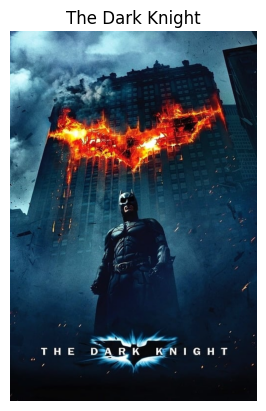

Recommendation



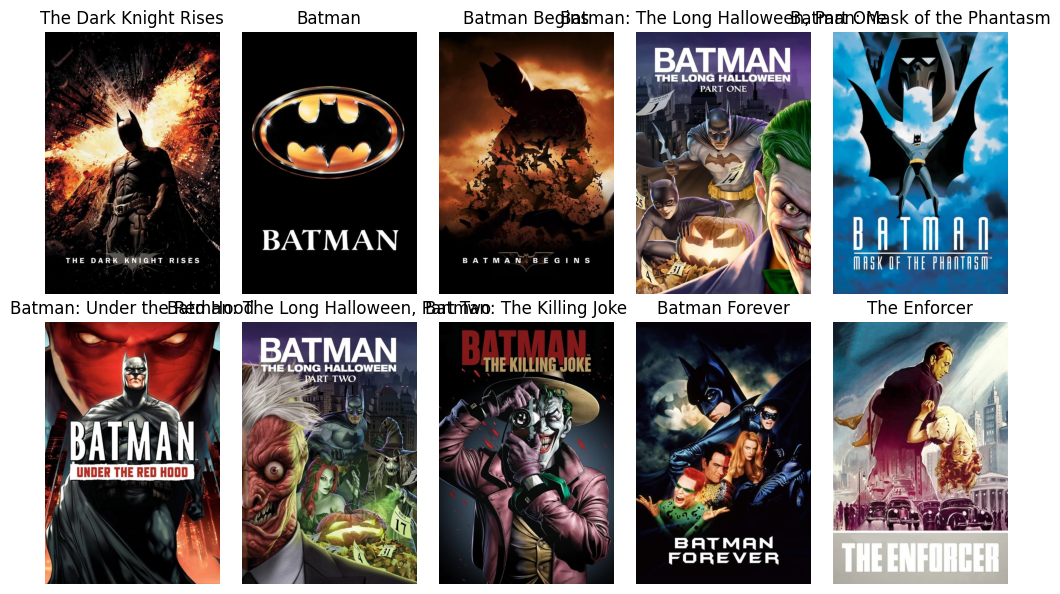

In [31]:
from skimage import io
import matplotlib.pyplot as plt

def get_recommendation(title):
    # Get the index of the movie that matches the title
    try:
        idx = df1.index[df1['title'] == title][0]
    except IndexError:
        print("Movie not found in dataset.")
        return
    
    # Show the given movie poster
    try:
        movie_poster = io.imread(f'https://image.tmdb.org/t/p/w500/{df1.loc[idx, "poster_path"]}')
        plt.imshow(movie_poster)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except:
        pass

    print('Recommendation\n')
    
    # Get the pairwise similarity scores for all movies with that movie
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix, tfidf_matrix[idx])))
    
    # Sort the movies based on the similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top 10 most similar movies
    sim_scores = sim_scores[1:11]  # Changed to get top 10
    
    # Get the movies indices
    movies_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = df1.iloc[movies_indices]

    # Show the recommendation
    fig, ax = plt.subplots(2, 5, figsize=(10, 6))  # Changed to 2 rows, 5 columns for 10 recommendations
    ax = ax.flatten()  # to iterate over all the objects by converting it into a 1D array.
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title)
            movie_poster = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(movie_poster)
        except:
            pass
    fig.tight_layout()
    plt.show()

get_recommendation("The Dark Knight")


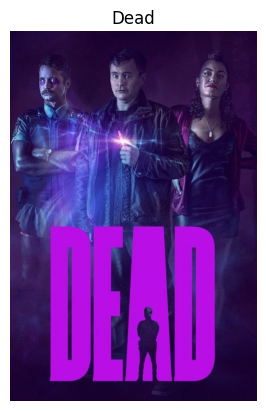

Recommendation



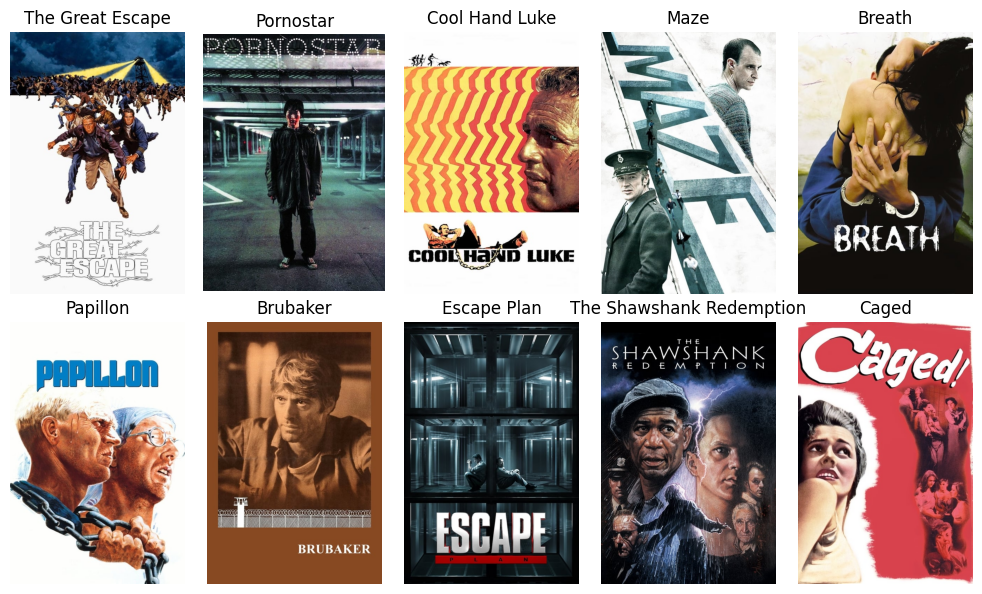

In [32]:
get_recommendation("Dead")

In [29]:
get_recommendation("Avengers")

Movie not found in dataset.


In [30]:
get_recommendation("Starwar")

Movie not found in dataset.
